<a href="https://colab.research.google.com/github/csnsnigdha18/Time-Series-Forecasting-and-Point-Anomaly-Detection-of-Sensor-Signals-Using-LSTM-Neural-Network-Arch/blob/main/Code/Covid19_Cases_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
country = "US"
#country = 'India'

In [ ]:
#Total COVID confirmed cases
df_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

Total days in the dataset 995


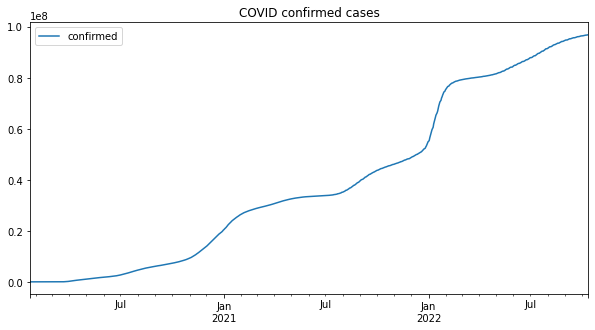

In [ ]:
#df_confirmed.to_csv('global.csv')
df_confirmed_country = df_confirmed[df_confirmed["Country/Region"] == country]
df_confirmed_country = pd.DataFrame(df_confirmed_country[df_confirmed_country.columns[4:]].sum(),columns=["confirmed"])
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index,format='%m/%d/%y')

df_confirmed_country.plot(figsize=(10,5),title="COVID confirmed cases")

df_confirmed_country.tail(10)

print("Total days in the dataset", len(df_confirmed_country))

In [ ]:
#Use data until 14 days before as training
x = len(df_confirmed_country)-14

train=df_confirmed_country.iloc[:x]
test = df_confirmed_country.iloc[x:]

##scale or normalize data as the data is too skewed
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [ ]:
## Use TimeSeriestrain_generator to generate data in sequences.
#Alternatively we can create our own sequences.
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
#Sequence size has an impact on prediction, especially since COVID is unpredictable!
seq_size = 7  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) # 271
print("Total number of samples in the generated data = ", len(train_generator)) # 264 with seq_size=7


Total number of samples in the original training data =  981
Total number of samples in the generated data =  974


In [ ]:
#Check data shape from generator
x,y = train_generator[10]  #Check train_generator
#Takes 7 days as x and 8th day as y (for seq_size=7)


In [ ]:
#Also generate test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7

Total number of samples in the original training data =  14
Total number of samples in the generated data =  7


In [ ]:
#Check data shape from generator
x,y = test_generator[0]

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

In [ ]:
#Define Model
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')
##########################

history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=50, steps_per_epoch=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 150)            91200     
                                                                 
 lstm_1 (LSTM)               (None, 64)                55040     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


10/10 [==============================] - 3s 62ms/step - loss: 0.5227 - val_loss: 0.2803
Epoch 2/50
10/10 [==============================] - 0s 15ms/step - loss: 0.0408 - val_loss: 0.0282
Epoch 3/50
10/10 [==============================] - 0s 20ms/step - loss: 0.0223 - val_loss: 0.0614
Epoch 4/50
10/10 [==============================] - 0s 39ms/step - loss: 0.0187 - val_loss: 2.3106e-07
Epoch 5/50
10/10 [==============================] - 0s 32ms/step - loss: 0.0090 - val_loss: 0.0154
Epoch 6/50
10/10 [==============================] - 0s 27ms/step - loss: 0.0050 - val_loss: 0.0317
Epoch 7/50
10/10 [==============================] - 0s 36ms/step - loss: 0.0027 - val_loss: 7.5892e-04
Epoch 8/50
10/10 [==============================] - 0s 44ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 9/50
10/10 [==============================] - 0s 34ms/step - loss: 3.9758e-04 - val_loss: 2.4918e-04
Epoch 10/50
10/10 [==============================] - 0s 19ms/step - loss: 1.2814e-04 - val_loss: 2.8442e

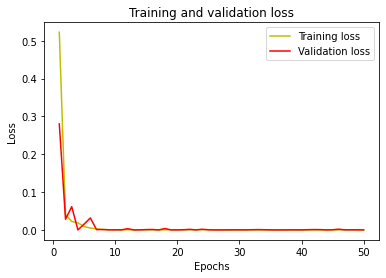

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape


In [ ]:
## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 18ms/step


In [ ]:
### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data


In [ ]:
#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

In [ ]:
#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]


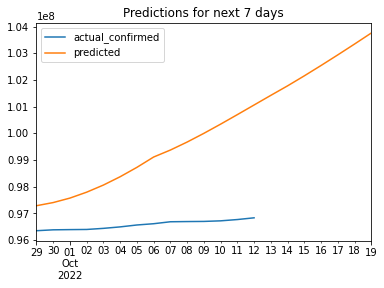

In [ ]:
#Plot
df_forecast.plot(title="Predictions for next 7 days")

